In [1]:
using Revise
using HypergraphNB
using DataFrames
using Clustering
using Statistics
using RCall
using Arpack
using Plots
using LinearAlgebra
using StatsBase
using MultivariateStats
import Random

┌ Info: Precompiling HypergraphNB [2dbe4ab3-0c84-4f8d-86d2-f64d6d698dce]
└ @ Base loading.jl:1260
┌ Warning: Package HypergraphNB does not have StatsBase in its dependencies:
│ - If you have HypergraphNB checked out for development and have
│   added StatsBase as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with HypergraphNB
└ Loading StatsBase into HypergraphNB from project dependency, future warnings for HypergraphNB are suppressed.


In [138]:
function experiment(N, C, P₂, P₃, P₄)
    
    P2, P3, P4, MI, EV = zeros(0), zeros(0), zeros(0), zeros(0), zeros(0)
    
    for p₂ ∈ P₂, p₃ ∈ P₃, p₄ ∈ P₄
        P = [NaN, p₂, p₃, p₄]
        
        H = plantedPartitionHypergraph(N, C, P)
        
        # only used for estimating the degree tensor
        z = vcat([repeat([z], N[z]) for z ∈ 1:length(N)]...)
        B = reducedBPJacobian(H, z)
                
        try 
            E = Arpack.eigs(B; nev = length(N), ritzvec = true)            
            V = hcat([HypergraphNB.transform_eigenvector(real.(E[2][:,i]), H) for i ∈ 1:length(N)]...)
            V = real.(V)
            V = V .> 0 # experiment
            clus = Clustering.kmeans(V', 2)
            clusters = Clustering.assignments(clus)
            
            mi = mutualinfo(clusters, z)
            append!(P2, p₂)
            append!(P3, p₃)
            append!(P4, p₄)
            append!(MI, mi)
        catch e
            nothing
        end
    end
    DF = DataFrame(
        P_2 = P2, 
        P_3 = P3,
        P_4 = P4,
        MI = MI
    )
    return DF
end

experiment (generic function with 1 method)

In [148]:
n_reps = 10
DF = DataFrame()

N = [100, 100]
C = [NaN, 5, 5, 0]

for rep ∈ 1:n_reps
    println("round $(rep)")
    df = experiment(N, C, 0.0:0.05:1, 0.0:0.05:1, [0]);
    append!(DF, df)
end

round 1
round 2
round 3
round 4
round 5
round 6
round 7
round 8
round 9
round 10


In [152]:
DF

,P_2,P_3,P_4,MI
,Float64,Float64,Float64,Float64
1,0.0,0.0,0.0,1.0
2,0.0,0.05,0.0,1.0
3,0.0,0.1,0.0,0.888843
4,0.0,0.15,0.0,1.0
5,0.0,0.2,0.0,1.0
6,0.0,0.25,0.0,0.00960026
7,0.0,0.3,0.0,1.0
8,0.0,0.35,0.0,0.959566
9,0.0,0.4,0.0,0.0021096


┌ Warning: RCall.jl: `summarise()` regrouping output by 'P_2', 'P_3' (override with `.groups` argument)
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


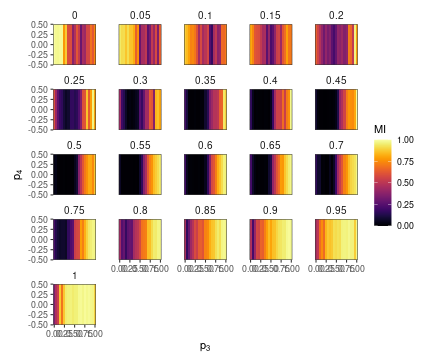

RObject{VecSxp}


In [153]:
R"""
library(tidyverse)
library(viridis)

df <- $DF %>%
    group_by(P_2, P_3, P_4) %>% 
    summarise(MI = mean(MI, na.rm = T))

p <- df %>% 
    ggplot() + 
    aes(x = P_3, y = P_4, fill = MI) + 
    geom_tile() + 
    theme_bw() + 
    scale_fill_viridis(option = "inferno", limits = c(0, 1)) + 
    scale_x_continuous(expand = c(0,0)) + 
    scale_y_continuous(expand = c(0,0)) + 
    xlab(expression(p[3])) + 
    ylab(expression(p[4])) + 
    theme(strip.background = element_blank(),
          panel.spacing.x = unit(8, "mm"),
          strip.text = element_text(size = 10)) +
    coord_fixed() +
    facet_wrap(~P_2)
"""

┌ Warning: RCall.jl: `summarise()` regrouping output by 'P_2', 'P_3' (override with `.groups` argument)
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


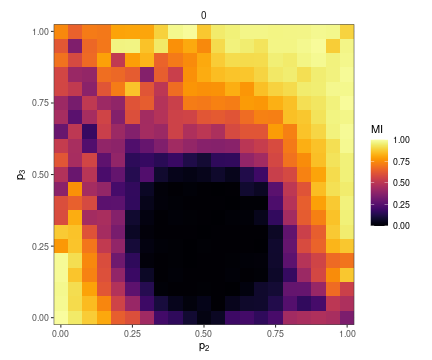

RObject{VecSxp}


In [154]:
R"""

df <- $DF %>%
    group_by(P_2, P_3, P_4) %>% 
    summarise(MI = mean(MI, na.rm = T))

p <- df %>% 
    ggplot() + 
    aes(x = P_2, y = P_3, fill = MI) + 
    geom_tile() + 
    theme_bw() + 
    scale_fill_viridis(option = "inferno", limits = c(0, 1)) + 
    scale_x_continuous(expand = c(0,0)) + 
    scale_y_continuous(expand = c(0,0)) + 
    xlab(expression(p[2])) + 
    ylab(expression(p[3])) + 
    theme(strip.background = element_blank(),
          panel.spacing.x = unit(8, "mm"),
          strip.text = element_text(size = 10)) +
    coord_fixed() +
    facet_wrap(~P_4)
"""